# Shortest Path - Generative Algorithm
Raisal P Wardana - 13319072

Please use the Markdown Headers to quickly navigate into each code sections

# Environment

In [2]:
import random
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
from shapely.geometry import LineString, Point
import numpy as np

# Function to calculate distance between two nodes
def distance(node1, node2):
    x1, y1 = node1
    x2, y2 = node2
    return ((x2 - x1)**2 + (y2 - y1)**2)**0.5

def find_intersection(line1, line2):
    line1 = LineString(line1)
    line2 = LineString(line2)
    intersection = line1.intersection(line2)
    if intersection.is_empty:
        return None
    if isinstance(intersection, Point):
        return round(intersection.x), round(intersection.y)
    return None

# Function to pre-calculate edge lengths and store them in a dictionary
def calculate_edge_lengths(graph):
    edge_lengths = {}
    for edge in graph.edges():
        x1, y1 = edge[0]
        x2, y2 = edge[1]
        edge_length = ((x2 - x1)**2 + (y2 - y1)**2)**0.5
        edge_lengths[edge] = edge_length
    return edge_lengths

## Generate Environment

In [3]:

### GENERATE RANDOM NODES ###
## PARAMETERS ##
num_nodes = 50
max_edges = 5
random.seed(42)
np.random.seed(42)

## CODE ##
# Generate Nodes
nodes = [(random.randint(0, 1000), random.randint(0, 1000)) for _ in range(num_nodes)]
nodes = list(set(nodes))  # Remove duplicates

# Connect to Closest Nodes
closest_edges = []
for node in nodes:
    distances = [(target, distance(node, target)) for target in nodes if target != node]
    sorted_distances = sorted(distances, key=lambda x: x[1])
    num_edges = random.randint(1, 7)
    for target, _ in sorted_distances[:num_edges]:
        closest_edges.append((node, target))

# Remove Self-loop edges
loop = 1
while(loop):
    loop = 0
    for edge in closest_edges:
        if edge[0] == edge[1]:
            closest_edges.remove(edge)
            loop = 1

# Randomize Speeds
edge_speeds = {}
for edge in closest_edges:
    speed = random.uniform(5, 50)
    edge_speeds[edge] = speed

# Make the graphs
G_closest = nx.DiGraph()
for node in nodes:
    G_closest.add_node(node)

# Add the edges
for edge, speeds in edge_speeds.items():
    G_closest.add_edge(edge[0],edge[1])

# Calculate edge lengths
edge_lengths = calculate_edge_lengths(G_closest)  

## Visualization

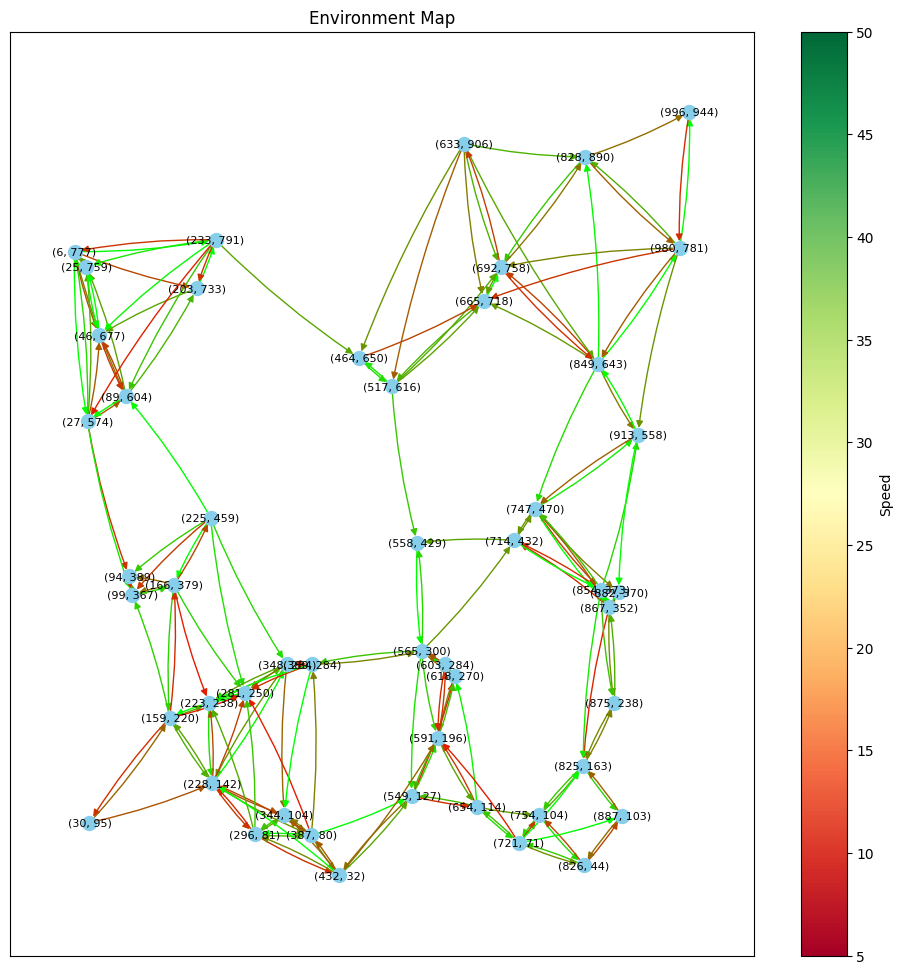

In [28]:

# Visualization


fig, ax = plt.subplots(figsize=(12,12))
pos = {node: node for node in nodes}

# Draw edges with colors and bidirectional arrows
edge_colors = []
for edge, speeds in edge_speeds.items():
        color = speeds/(50-5)
        RGB = np.clip([1-color,color,0,1],0,1)
        edge_colors.append(RGB)

nx.draw_networkx(G_closest, pos, nodelist=nodes, with_labels=True, node_color='skyblue', node_size=100, font_size=8, node_shape='o',edgelist=edge_speeds, edge_color=edge_colors, arrows=True, arrowstyle='-|>', connectionstyle='arc3,rad=0.05')

# Create a colormap for the speeds
cmap = plt.cm.RdYlGn
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=5, vmax=50))
sm.set_array([])
plt.colorbar(sm, ax=ax, orientation='vertical', label='Speed')

# Draw edge labels
#closest_labels = {f"{speeds:.1f}" for edge, speeds in edge_speeds.items()}
#nx.draw_networkx_edge_labels(G_closest, pos, edge_labels=closest_labels, font_size=8)

# Draw node labels
#for node, (x, y) in pos.items():
#    plt.text(x, y+0.2, str(node), fontsize=12, ha='center')

plt.title("Environment Map")
plt.show()

In [5]:
# Debugging: Initialize one chromosome to inspect the variables
#debug_initialize_chromosome(start_node, end_node, G_closest, chromosome_length)


# Generative Algorithm

## Start and End Nodes

In [6]:
# PARAMETERS
start_node = (30,95)
end_node = (828,890)

## Codes

### Initialization

In [ ]:
# Function to initialize a chromosome
def initialize_chromosome(start_node, end_node, graph, length):
    chromosome = [start_node]
    current_node = start_node
    while len(chromosome) < length - 1:
        if current_node == end_node:
          #print("arrived at end node")
          break
        legal_moves = [node for node in graph.neighbors(current_node)]
        if not legal_moves:
            break
        next_node = random.choice(legal_moves)
        chromosome.append(next_node)
        current_node = next_node

    #chromosome.append(end_node)
    return chromosome

### Fitness Evaluation

In [ ]:
def calc_travel_time(chromosome,edge_speeds, edge_lengths):
    total_travel_time = 0
    for i in range(len(chromosome) - 1):
        edge = (chromosome[i], chromosome[i + 1])

        # Retrieve the pre-calculated length of the edge
        if edge in edge_lengths:
          edge_length = edge_lengths[edge]

          # Calculate the travel time for the edge
          travel_time = edge_length / edge_speeds[edge]

          # Deduct the travel time from the fitness
          total_travel_time += travel_time
    return total_travel_time

# Function to evaluate the fitness of a chromosome using pre-calculated edge lengths
def evaluate_fitness(chromosome, edge_lengths, edge_speeds):
    fitness = 0  # Starting fitness points
    visited = []
    for i in range(len(chromosome) - 1):
        edge = (chromosome[i], chromosome[i + 1])

        # Retrieve the pre-calculated length of the edge
        if edge in edge_lengths:
          edge_length = edge_lengths[edge]

          # Calculate the travel time for the edge
          travel_time = edge_length / edge_speeds[edge]

          # Deduct the travel time from the fitness
          fitness += (travel_time**2)
        else:
          fitness += 5000
        if chromosome[i] in visited:
          fitness += 1000
        visited.append(chromosome[i])

    if chromosome[-1] != end_node:
      fitness += 100000
    return fitness

### Selection, Crossover, and Mutation

In [ ]:
# Function for Roulette Wheel Selection
def roulette_wheel_selection(population_size, fitness_values, random_population_rate=0.2):
    inverted_fitness_values = [1 / (f**3) for f in fitness_values]
    total_fitness = sum(inverted_fitness_values)
    normalized_fitness_values = [f / total_fitness for f in inverted_fitness_values]
    return np.random.choice(population_size, size=int(population_size*(1-random_population_rate)), p=normalized_fitness_values)

# Function for One-Point Crossover
def one_point_crossover(parent1, parent2):
    # Step 1 & 2: Identify identical nodes and their indices in both parents
    identical_nodes = {}

    for i, node in parent1:
      if node != start_node and node != end_node:
        if node in parent2:
            if node not in identical_nodes:
                identical_nodes[node][0].append(i)

    for i, node in parent2:
      if node != start_node and node != end_node:
        if node in parent1:
            if node not in identical_nodes:
                identical_nodes[node][1].append(i)

    # Step 3: Randomly choose one such node and the corresponding indices
    if len(identical_nodes) != 0:
      chosen_node = random.choice(list(identical_nodes.keys()))
      chosen_idx1 = random.choice(identical_nodes[chosen_node][0])
      chosen_idx2 = random.choice(identical_nodes[chosen_node][1])
    else:
      return parent1,parent2

    # Step 4: Use these indices to split and merge the parent chromosomes to create offspring
    offspring1 = parent1[:chosen_idx1] + parent2[chosen_idx2+1:]
    offspring2 = parent2[:chosen_idx2] + parent1[chosen_idx1+1:]
    print(offspring1,offspring2)
    return offspring1, offspring2


# Function for Mutation
def mutate_chromosome(chromosome, graph, chromosome_length, mutation_rate=0.05):
    if random.random() < mutation_rate:
        mutation_point = random.randint(1, len(chromosome) - 2)
        legal_moves = [node for node in graph.neighbors(chromosome[mutation_point])]
        if legal_moves:
            mutation = initialize_chromosome(chromosome[mutation_point],end_node, graph, chromosome_length-len(chromosome[:mutation_point]))
            chromosome = chromosome[:mutation_point] + mutation[1:]
    return chromosome

### Genetic Algorithm Function

In [7]:
# Function to run the Genetic Algorithm for multiple generations
def run_genetic_algorithm(graph, edge_speeds, edge_lengths, start_node, end_node, population_size, chromosome_length, num_generations, mutation_rate=0.05, random_population_rate=0.2):
    population = [initialize_chromosome(start_node, end_node, graph, chromosome_length) for _ in range(population_size)]
    best_chromosome = []
    best_fitness = []
    average_travel_time = []
    #print(edge_lengths)
    for generation in range(num_generations):
        fitness_values = [evaluate_fitness(chromosome, edge_lengths, edge_speeds) for chromosome in population]
        min_fitness = min(fitness_values)
        best_fitness.append(min_fitness)
        best_chromosome.append(population[fitness_values.index(min_fitness)])
        travel_times = [calc_travel_time(chromosome, edge_speeds, edge_lengths) for chromosome in population]

        average_travel_time.append(np.mean(travel_times))
        selected_parent_indices = roulette_wheel_selection(population_size, fitness_values, random_population_rate)
        selected_parents = [population[i] for i in selected_parent_indices]
        #print(selected_parent_indices)
        next_generation = []
        for i in range(0, len(selected_parents), 2):
            parent1 = selected_parents[i]
            parent2 = selected_parents[i+1]
            offspring1, offspring2 = one_point_crossover(parent1, parent2)
            next_generation.extend([offspring1, offspring2])
        mutated_offspring = [mutate_chromosome(chromosome, graph,chromosome_length, mutation_rate) for chromosome in next_generation]
        #mutated_offspring = next_generation

        random_population = [initialize_chromosome(start_node, end_node, graph, chromosome_length) for _ in range(int(population_size*random_population_rate))]

        population = mutated_offspring + random_population
        mutation_rate = mutation_rate * (num_generations - generation)/num_generations

    return best_chromosome, best_fitness, average_travel_time



## Running the Generative Algorithm

Best route found: [(30, 95), (228, 142), (387, 80), (432, 32), (591, 196), (603, 284), (565, 300), (714, 432), (854, 373), (913, 558), (849, 643), (828, 890)]


Text(0, 0.5, 'Fitness')

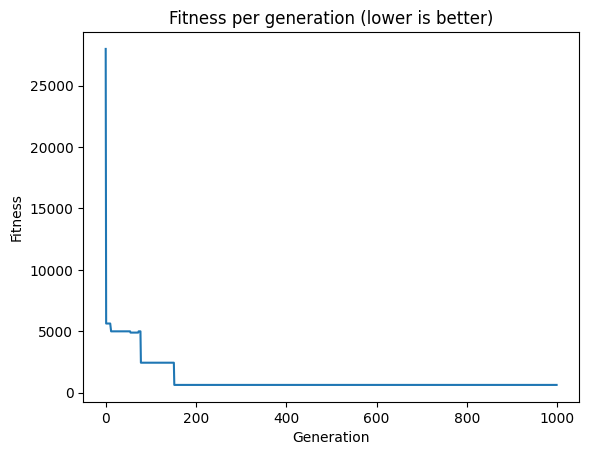

In [32]:
# Hyperparameters
mutation_rate = 0.95
random_population_rate = 0.4
population_size = 100
chromosome_length = 50
num_generations = 1000

best_chromosome, best_fitness, avg_travel_time = run_genetic_algorithm(
    G_closest,
    edge_speeds,
    edge_lengths,
    start_node,
    end_node,
    population_size,
    chromosome_length,
    num_generations,
    mutation_rate=mutation_rate,
    random_population_rate=random_population_rate
)

best_chromosome_lengths = [len(chromosome) for chromosome in best_chromosome]
print("Best route found:", best_chromosome[-1])
plt.plot(best_fitness)
plt.title('Fitness per generation (lower is better)')
plt.xlabel('Generation')
plt.ylabel('Fitness')

Text(0, 0.5, 'Average Travel Time')

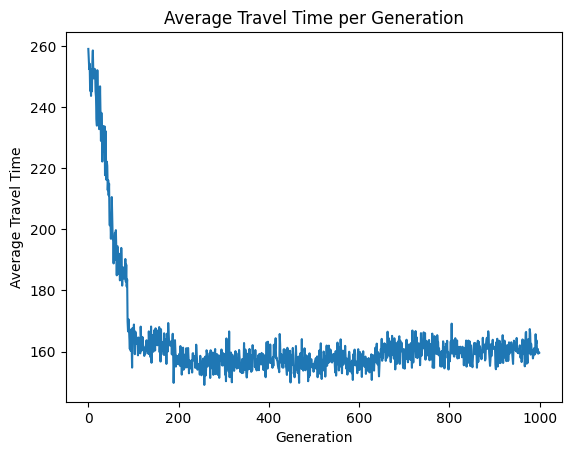

In [16]:
plt.plot(avg_travel_time)
plt.title("Average Travel Time per Generation")
plt.xlabel('Generation')
plt.ylabel('Average Travel Time')

### Path Visualization

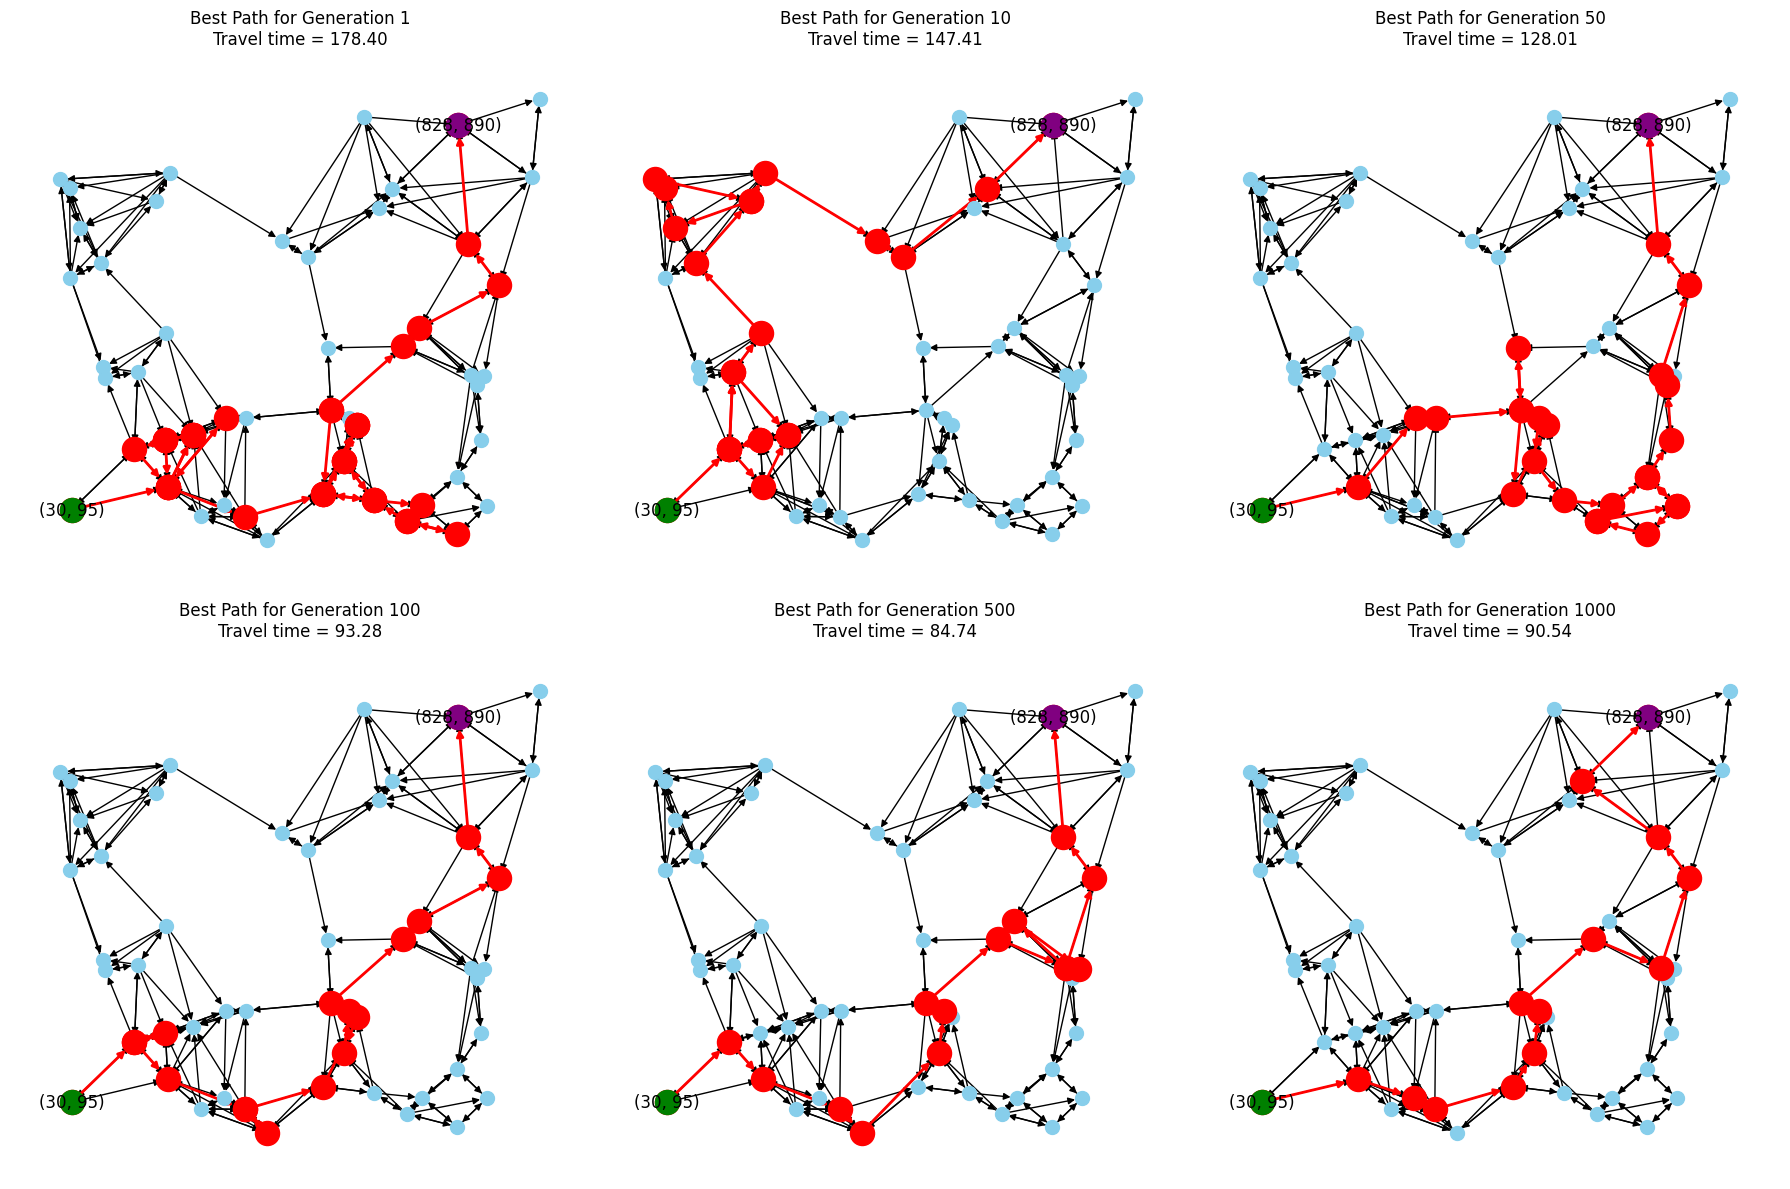

In [19]:
# Create a figure and axis for the 2x3 plot
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# Key generations you're interested in
key_generations = [1, 10, 50, 100, 500, 1000]

# Sample best chromosomes for key generations (Replace this with actual best chromosomes)
key_best_chromosomes = {key:best_chromosome[key-1] for key in key_generations}


# Loop through each subplot to plot the path for each key generation
for ax, generation in zip(axs.flat, key_best_chromosomes.keys()):
    chromosome = key_best_chromosomes[generation]
    pos = {node: node for node in G_closest.nodes()}  # Assuming nodes are coordinates

    # Basic graph layout
    nx.draw(G_closest, pos, with_labels=False, node_color='skyblue', node_size=100, font_size=8, ax=ax)

    # Highlight nodes in the path
    nx.draw_networkx_nodes(G_closest, pos, nodelist=chromosome, node_color='r', ax=ax, node_size=100)

    # Highlight edges in the path
    path_edges = [(chromosome[i], chromosome[i + 1]) for i in range(len(chromosome) - 1)]
    nx.draw_networkx_edges(G_closest, pos, edgelist=path_edges, edge_color='r', width=2, ax=ax)

    # Color start and end nodes
    nx.draw_networkx_nodes(G_closest, pos, label=start_node, nodelist=[start_node], node_color='g', ax=ax)
    nx.draw_networkx_labels(G_closest, pos, labels={start_node:pos[start_node]}, font_size=12, ax=ax)
    nx.draw_networkx_nodes(G_closest, pos, label=end_node, nodelist=[end_node], node_color='purple', ax=ax)
    nx.draw_networkx_labels(G_closest, pos, labels={end_node:pos[end_node]}, font_size=12, ax=ax)

    ax.set_title(f"Best Path for Generation {generation}\nTravel time = {calc_travel_time(chromosome,edge_speeds, edge_lengths):.2f}")

plt.tight_layout()
plt.show()

#### Animation

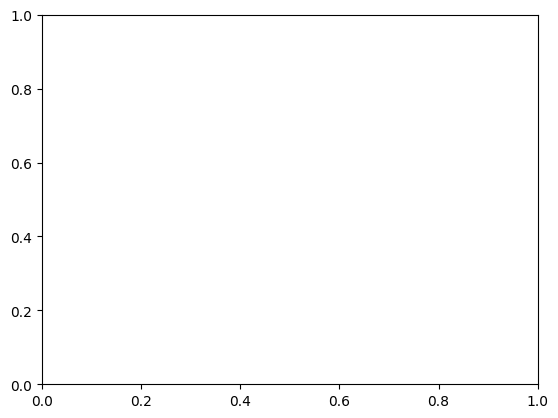

In [37]:
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter


# Function to plot generation and update the plot for animation
def update(frame, graph, key_best_chromosomes, ax, generations, generation_start_frame):
    ax.clear()
    pos = {node: node for node in graph.nodes()}  # Assuming nodes are coordinates
    nx.draw(graph, pos, with_labels=False, node_color='skyblue', node_size=100, font_size=8, ax=ax)

    current_generation = generations[0]

    for i in range(1,len(generations)):
        if frame >= generation_start_frame[generations[i]]:
          current_generation = generations[i]
    
    frame -= generation_start_frame[current_generation]


    best_chromosome = key_best_chromosomes.get(current_generation, None)
    if best_chromosome:
        # Draw the path up to the current frame (node)
        sub_path = best_chromosome[:frame + 1]
        prev_path = best_chromosome[:frame] if frame > 0 else []

        # Highlight nodes in the sub path
        nx.draw_networkx_nodes(graph, pos, nodelist=sub_path, node_color='r', ax=ax)

        # Highlight edges in the sub path
        sub_edges = [(sub_path[i], sub_path[i + 1]) for i in range(len(sub_path) - 1)]
        nx.draw_networkx_edges(graph, pos, edgelist=sub_edges, edge_color='r', width=2, ax=ax)

        # Highlight nodes in the previous path
        nx.draw_networkx_nodes(graph, pos, nodelist=prev_path, node_color='orange', ax=ax)

        # Highlight edges in the previous path
        prev_edges = [(prev_path[i], prev_path[i + 1]) for i in range(len(prev_path) - 1)]
        nx.draw_networkx_edges(graph, pos, edgelist=prev_edges, edge_color='orange', width=2, ax=ax)



    # Color start and end nodes
    nx.draw_networkx_nodes(graph, pos, label=start_node, nodelist=[start_node], node_color='g', ax=ax)
    nx.draw_networkx_labels(graph,pos, labels={start_node:pos[start_node]}, font_size=12)
    nx.draw_networkx_nodes(graph, pos, label=end_node, nodelist=[end_node], node_color='purple', ax=ax)
    nx.draw_networkx_labels(graph, pos, labels={end_node:pos[end_node]}, font_size=12)

    ax.set_title(f"Best Path for Generation {current_generation} - Node {frame}")



# Create a figure and axis for the plot
fig, ax = plt.subplots()

# Key generations you're interested in
key_generations = [1, 10, 50, 100, 500, 1000]

# Sample best chromosomes for key generations (Replace this with actual best chromosomes)
key_best_chromosomes = {key:best_chromosome[key-1] for key in key_generations}

generation_frame_length = {key:len(key_best_chromosomes[key]) for key in key_generations}
generation_start_frame = {key_generations[0]:0}

for i in range(1, len(key_generations)):
  generation_start_frame[key_generations[i]] = generation_start_frame[key_generations[i-1]] + generation_frame_length[key_generations[i-1]]

# Create animation
ani = FuncAnimation(fig, update, frames=sum(generation_frame_length.values()), fargs=(G_closest, key_best_chromosomes, ax, key_generations, generation_start_frame), repeat=False)

plt.show()


C:\Users\raisa\AppData\Local\Temp\ipykernel_21460\3602387947.py:31: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(graph, pos, edgelist=sub_edges, edge_color='r', width=2, ax=ax)
C:\Users\raisa\AppData\Local\Temp\ipykernel_21460\3602387947.py:38: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(graph, pos, edgelist=prev_edges, edge_color='orange', width=2, ax=ax)


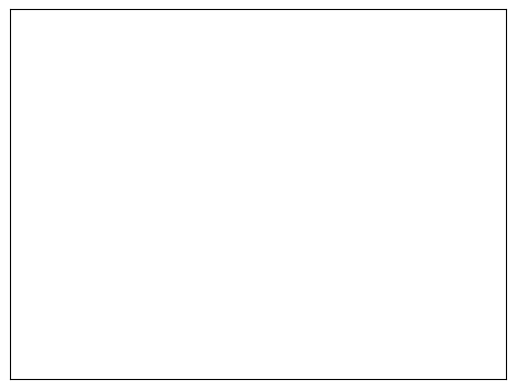

In [38]:
# Write the animation to a .gif file
writer = PillowWriter(fps=10)
ani.save("best_path_animation.gif", writer=writer)

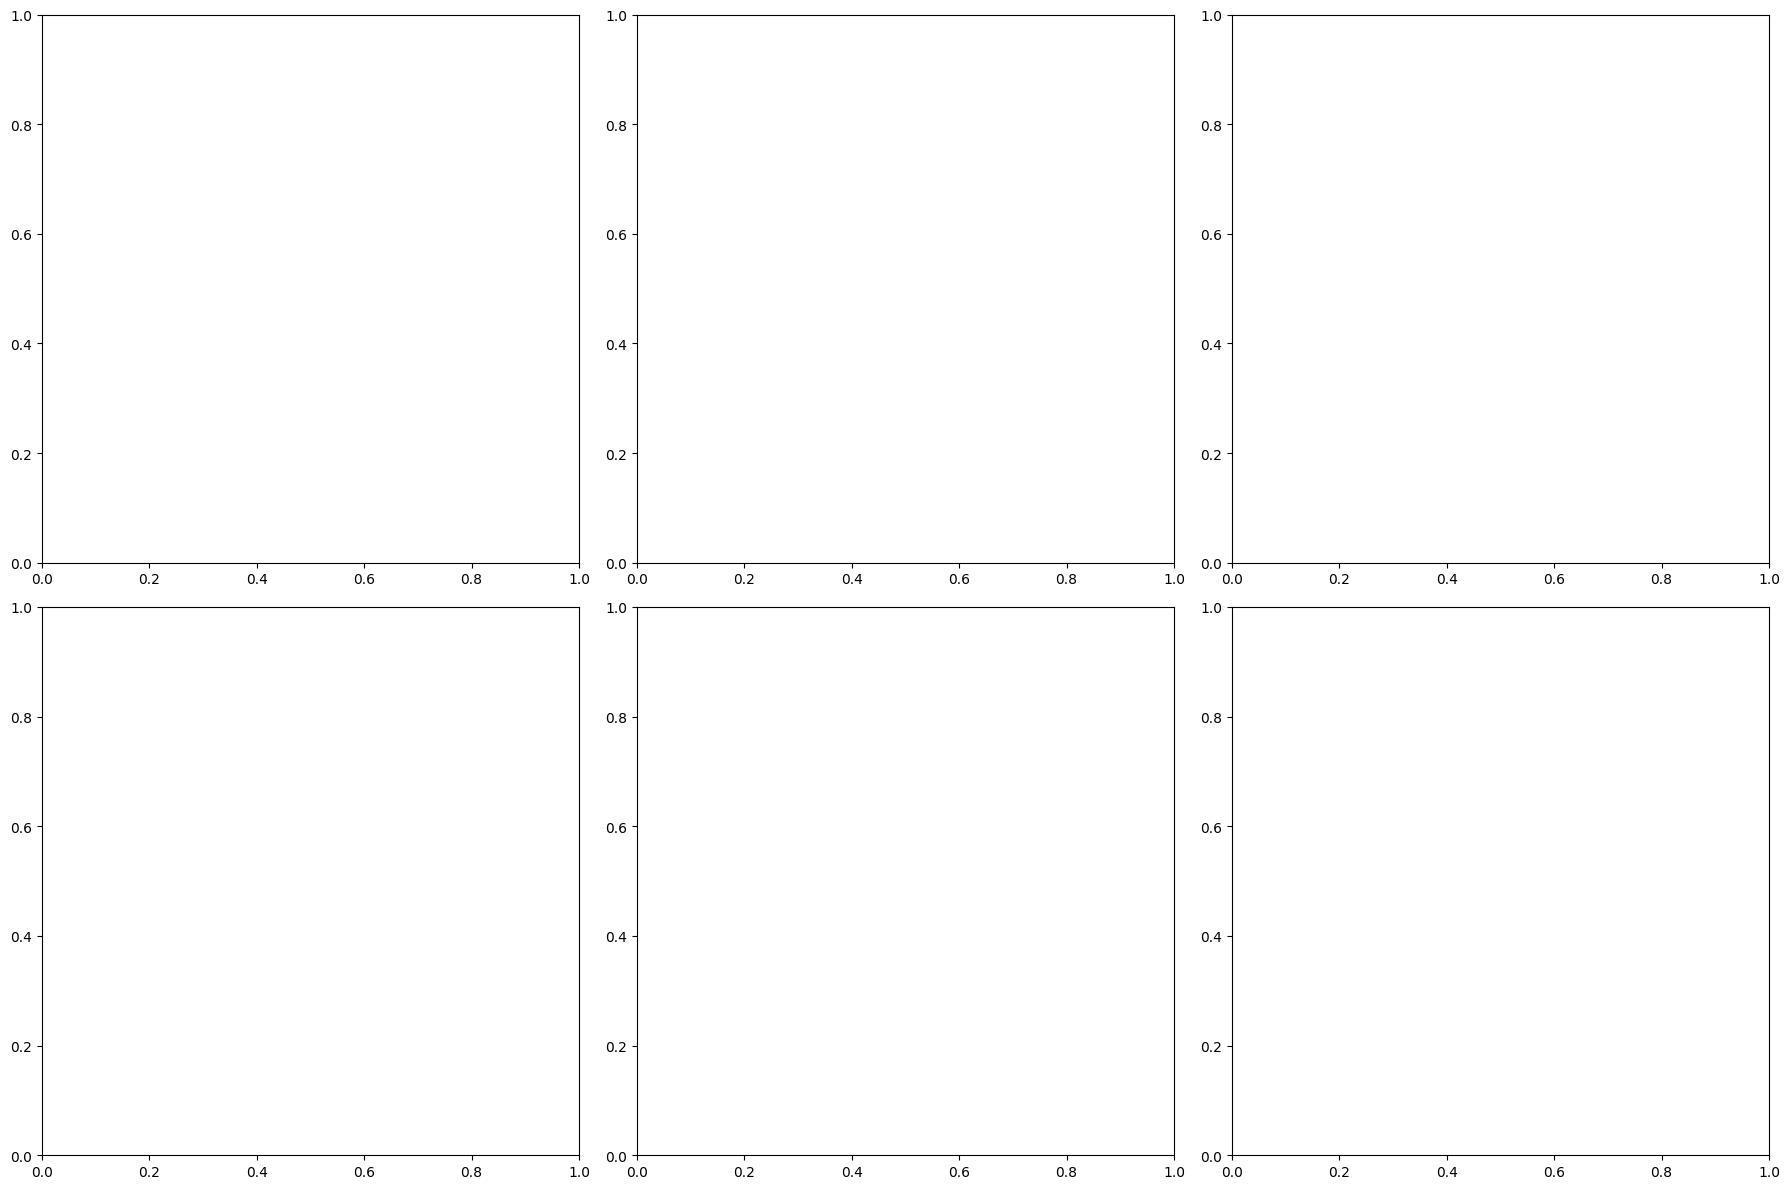

IndexError: list index out of range

In [ ]:
### NOT WORKING ###

# Function to plot generation and update the plot for animation in a 2x3 subplot layout
def update_matrix(frame, graph, key_best_chromosomes, axs, generations, generation_start_frame):
    for ax, current_generation in zip(axs.flat, generations):
        ax.clear()
        pos = {node: node for node in graph.nodes()}  # Assuming nodes are coordinates
        nx.draw(graph, pos, with_labels=False, node_color='skyblue', node_size=100, font_size=8, ax=ax)

        # Determine the current frame for each subplot based on the generation_start_frame
        local_frame = frame
        for i in range(len(generations)):
            if generation_start_frame[generations[i]] < frame:
                current_generation = generations[i]
                local_frame = frame - generation_start_frame[generations[i]]
                break

        best_chromosome = key_best_chromosomes.get(current_generation, None)
        if best_chromosome:
            max_frame = min(local_frame, len(best_chromosome) - 1)  # Stay at the last frame if reached the end
            sub_path = best_chromosome[:max_frame + 1]
            prev_path = best_chromosome[:max_frame] if max_frame > 0 else []

            # Highlight nodes in the previous path
            nx.draw_networkx_nodes(graph, pos, nodelist=prev_path, node_color='orange', ax=ax)

            # Highlight edges in the previous path
            prev_edges = [(prev_path[i], prev_path[i + 1]) for i in range(len(prev_path) - 1)]
            nx.draw_networkx_edges(graph, pos, edgelist=prev_edges, edge_color='orange', width=2, ax=ax)

            # Highlight nodes in the sub path
            nx.draw_networkx_nodes(graph, pos, nodelist=sub_path, node_color='r', ax=ax)

            # Highlight edges in the sub path
            sub_edges = [(sub_path[i], sub_path[i + 1]) for i in range(len(sub_path) - 1)]
            nx.draw_networkx_edges(graph, pos, edgelist=sub_edges, edge_color='r', width=2, ax=ax)

        # Color start and end nodes
        nx.draw_networkx_nodes(graph, pos, label=start_node, nodelist=[start_node], node_color='g', ax=ax)
        nx.draw_networkx_labels(graph, pos, labels={start_node: pos[start_node]}, font_size=12, ax=ax)
        nx.draw_networkx_nodes(graph, pos, label=end_node, nodelist=[end_node], node_color='purple', ax=ax)
        nx.draw_networkx_labels(graph, pos, labels={end_node: pos[end_node]}, font_size=12, ax=ax)

        ax.set_title(f"Best Path for Generation {current_generation} - Node {max_frame}")


# Create a figure and axis for the plot
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# Key generations you're interested in
key_generations = [1, 5, 10, 25, 50, 100]

# Sample best chromosomes for key generations (Replace this with actual best chromosomes)
key_best_chromosomes = {key:best_chromosome[key] for key in key_generations}

generation_frame_length = {key:len(key_best_chromosomes[key]) for key in key_generations}
generation_start_frame = {key_generations[0]:0}

# Create animation
ani = FuncAnimation(fig, update, frames=max(generation_frame_length.values()), fargs=(G_closest, key_best_chromosomes, axs, key_generations, generation_start_frame), repeat=False)

plt.tight_layout()
plt.show()

writer = PillowWriter(fps=10)
ani.save("2x3_best_path_animation.gif", writer=writer)